In [1]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

import pyfolio as pf

import ffn

from backtester import backtest as bt
from backtester import backtest_with_cost as btwc

%matplotlib inline

In [2]:
def create_pairs(tickers):
        result = []
        for p1 in range(len(tickers)):
                for p2 in range(p1+1,len(tickers)):
                        result.append([tickers[p1],tickers[p2]])
        return result
    
def get_closing(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    
    temp.columns = ['Date', 'Symbol', 'Interval', 'Open', 'High', 'Low', name, 'Volume']
    temp = temp[name]
    return temp

def get_volume(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    temp['OHLC4'] = (temp.OPEN + temp.HIGH + temp.LOW + temp.CLOSE) / 4 
    temp[name] = temp.VOLUME * temp.OHLC4
    
    temp = temp[name]
    return temp

    
def find_ssd(df, vol, vol_thres, pairs):
    
    ssd = {}
    for p in pairs:
        pair = p[0]+','+p[1]
        
        if vol[p[0]].mean(axis=0) < vol_thres or vol[p[1]].mean(axis=0) < vol_thres:
            #print(p[0], vol[p[0]].mean())
            #print(p[1], vol[p[1]].mean())
            continue
        
        A = df[p[0]]
        B = df[p[1]]
        
        s = np.sum((A-B)**2)
        
        if s == 0.0:
            #s = 999.9 
            continue
        
        if len(A.dropna()) < 248 or len(B.dropna()) < 248:
            #s = 999.9
            continue
            
        ssd[pair] = s
        
    return ssd


def find_tradeble_pairs(ssd, amount):
    sorted_lst = sorted(ssd, key=ssd.get)
    pair_lst = []
    if len(sorted_lst) < 1:
        return pair_lst
    elif amount < len(sorted_lst):       
        for n in range(amount):
            pair_lst.append(sorted_lst[n].split(","))
    else:
        for n in range(len(sorted_lst)):
            pair_lst.append(sorted_lst[n].split(","))

    return pair_lst


def find_entry_exit(spread, n):
    mean = np.mean(spread)
    stdev = np.std(spread)
    upper = mean+(n*stdev)
    lower = mean-(n*stdev)
    
    return mean, upper, lower

def create_signal(df, pair, m, u, l):
    spread = df[pair[0]] - df[pair[1]]
    previous_spread = spread.shift(1)
    bt_df = pd.DataFrame()
    
    bt_df[pair[0]] = df[pair[0]]
    bt_df[pair[1]] = df[pair[1]]
    bt_df['shortsignal'] = ((spread < u) & (previous_spread > u))
    bt_df['longsignal'] = ((spread > l) & (previous_spread < l))
    bt_df['closelong'] = np.where(spread >= m, 1, 0)
    bt_df['closeshort'] = np.where(spread <= m, 1, 0)
    
    return bt_df


def trading(df_formation, df_trading, vol, amount, n):
    returns = pd.DataFrame()
    
    vol_thres = vol.mean().quantile(0.25)
    print(vol_thres)
    #vol_thres = np.percentile(vol.fillna(0).mean(axis=1), 0.05)
    #print(vol_thres)
    
    ssd = find_ssd(df_formation, vol, vol_thres, pairs)
    selected = find_tradeble_pairs(ssd, amount)
    
    for pair in selected:
        bt_name = pair[0]+pair[1]
        print(bt_name)
        spread = df_formation[pair[0]] - df_formation[pair[1]]
        m, u, l = find_entry_exit(spread, n) 
        
        bt_df = create_signal(df_trading, pair, m, u, l)
        ret = bt(bt_df, pair[0], pair[1])
        
        returns[bt_name] = ret.returns
        
    returns['mean'] = returns.mean(axis=1)
    returns = returns.set_index(df_trading.index)
    return returns['mean']
    
    

def backtest(df, vol, amount, n):
    overall_ret = pd.DataFrame()
    
    start = pd.Timestamp('2000-01')
    mid = start + relativedelta(months=+12)
    end = start + relativedelta(months=+18)
    
    df_formation = (1 + df[start:mid].pct_change()).cumprod()
    df_trading = (1 + df[mid:end].pct_change()).cumprod()
    vol_df = vol[start:mid]
    
    returns = trading(df_formation, df_trading, vol_df, amount, n)
    overall_ret = returns
    
    print(start, mid, end)

    for period in range(1, 38):
        start = start + relativedelta(months=+6)
        mid = start + relativedelta(months=+12)
        end = start + relativedelta(months=+18)
        
        df_formation = (1 + df[start:mid].pct_change()).cumprod()
        df_trading = (1 + df[mid:end].pct_change()).cumprod()
        vol_df = vol[start:mid]

        returns = trading(df_formation, df_trading, vol_df, amount, n)
        overall_ret = overall_ret.append(returns)
        print(start, mid, end)
        
    return overall_ret

In [3]:
tickers = pd.read_excel('C:/Users/jango/Documents/BFH/BTHE/Sectors.xlsx', sheet_name=None)

hc_tickers = tickers['hc'].Ticker.tolist()
cg_tickers = tickers['cg'].Ticker.tolist()
fin_tickers = tickers['fin'].Ticker.tolist()
ind_tickers = tickers['ind'].Ticker.tolist()
all_tickers = tickers['all'].Ticker.tolist()

In [4]:
UBS = pd.read_csv('C:/Users/jango/code/research_env/BTHE/Datalink/csv/UBSG.csv', delimiter=";")
UBS.DATE = pd.to_datetime(UBS['DATE'].str[:10], dayfirst=True)
df = pd.DataFrame(UBS.CLOSE).set_index(UBS.DATE)
df.columns = ['UBS']
df = df.drop(columns=['UBS'])
vol = df.copy()

In [5]:
pairs = create_pairs(all_tickers)

In [6]:
for ticker in all_tickers:
    path = 'C:/Users/jango/code/research_env/BTHE/Datalink/csv/'+ticker+'.csv'
    df = df.join(get_closing(pd.read_csv(path, delimiter=";"), ticker)).ffill()
    vol = vol.join(get_volume(pd.read_csv(path, delimiter=";"), ticker)).ffill()
    #print(ticker + ' done')

In [14]:
ret = backtest(df, vol, 10, 0.5)

75831.13689049425
BSKPVATN
LLBNVATN
BLKBVATN
BSKPLLBN
BLKBLLBN
BLKBBSKP
BLKBISN
BSKPVPBN
VATNVPBN
LLBNVPBN
2000-01-01 00:00:00 2001-01-01 00:00:00 2001-07-01 00:00:00
76153.48947002564
BLKBPSPN
BLKBBSKP
BSKPPSPN
LLBNSPSN
BLKBSPSN
SPSNZUBN
PSPNSPSN
ALLNISN
BBNCFT
LLBNZUBN
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
89400.6248125
BLKBBSKP
BEKNPSPN
BLKBBEKN
BPDGPSPN
PSPNSPSN
ALLNPSPN
BPDGBEKN
BEKNSPSN
BPDGSPSN
BSKPBEKN
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
87086.55709028152
BSKPBEKN
BLKBBSKP
BLKBBEKN
BLKBSPSN
BLKBPSPN
BEKNSPSN
BSKPSPSN
BEKNZUBN
PSPNSPSN
BSKPZUBN
2001-07-01 00:00:00 2002-07-01 00:00:00 2003-01-01 00:00:00
114111.57209180653
BLKBBSKP
BSKPBEKN
BSKPLUKN
BEKNLUKN
PSPNSPSN
BPDGPSPN
BLKBBEKN
BLKBLUKN
BSKPPSPN
BPDGBLKB
2002-01-01 00:00:00 2003-01-01 00:00:00 2003-07-01 00:00:00
121424.5759771726
ALLNPSPN
LUKNSGKN
BEKNPSPN
BEKNWARN
BEKNSGKN
LUKNWARN
BEKNLUKN
BBNSPCE
SGKNWARN
ALLNBEKN
2002-07-01 00:00:00 2003-07-01 00:00:00 2004-01-01 00:00:00


Stats for mean from 2001-01-03 00:00:00 - 2019-12-30 00:00:00
Annual risk-free rate considered: 1.90%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-4.26%             -0.42  -0.23%  -20.94%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y     5y      10y     incep.
------  ------  ------  -----  -----  -----  ------  ------  --------
-0.71%  -1.87%  -0.61%  0.73%  0.73%  1.19%  -0.43%  -0.87%  -0.23%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -0.42    -0.48      -0.53
mean    -0.11%   -0.13%     0.02%
vol     4.80%    4.21%      3.52%
skew    -5.39    -2.67      -0.43
kurt    167.16   17.90      -0.69
best    2.17%    2.94%      5.20%
worst   -9.00%   -9.51%     -6.66%

Drawdowns:
max      avg       # days
-------  ------  --------
-20.94%  -1.34%    161.52

Misc:
---------------  ------
avg. up month    0.71%
avg. down month  -0.90%
up year %        50.00%
12m up %  

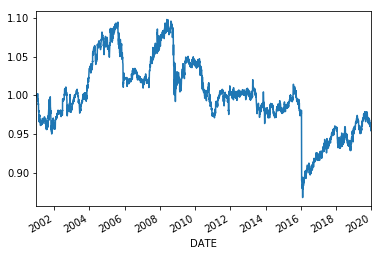

In [15]:
cum_ret = (1 + ret).cumprod()
cum_ret.plot()
perf = cum_ret.calc_stats()
perf.set_riskfree_rate(0.019)
perf.display()

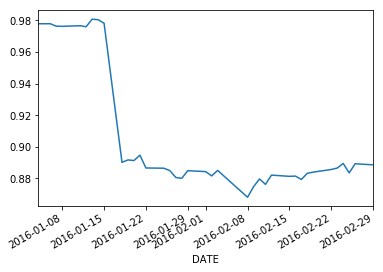

In [19]:
test = cum_ret['2016-01':'2016-02']
test.plot()

In [142]:
habab = pd.DataFrame(test.fillna(0).mean(axis=1))

In [42]:
backt = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_all_test.csv',index_col='DATE', parse_dates=True)
perf = backt.calc_stats()
perf.set_riskfree_rate(0.019)
perf.display()

Stat                 mean
-------------------  ----------
Start                2001-01-03
End                  2019-12-30
Risk-free rate       1.90%

Total Return         -12.76%
Daily Sharpe         -0.52
Daily Sortino        -0.80
CAGR                 -0.72%
Max Drawdown         -22.61%
Calmar Ratio         -0.03

MTD                  0.10%
3m                   -0.16%
6m                   -1.04%
YTD                  -1.73%
1Y                   -1.73%
3Y (ann.)            -1.37%
5Y (ann.)            -1.88%
10Y (ann.)           -1.71%
Since Incep. (ann.)  -0.72%

Daily Sharpe         -0.52
Daily Sortino        -0.80
Daily Mean (ann.)    -0.61%
Daily Vol (ann.)     4.74%
Daily Skew           -0.60
Daily Kurt           12.88
Best Day             2.59%
Worst Day            -4.00%

Monthly Sharpe       -0.76
Monthly Sortino      -1.13
Monthly Mean (ann.)  -0.67%
Monthly Vol (ann.)   3.34%
Monthly Skew         -0.61
Monthly Kurt         2.66
Best Month           2.79%
Worst Month          -

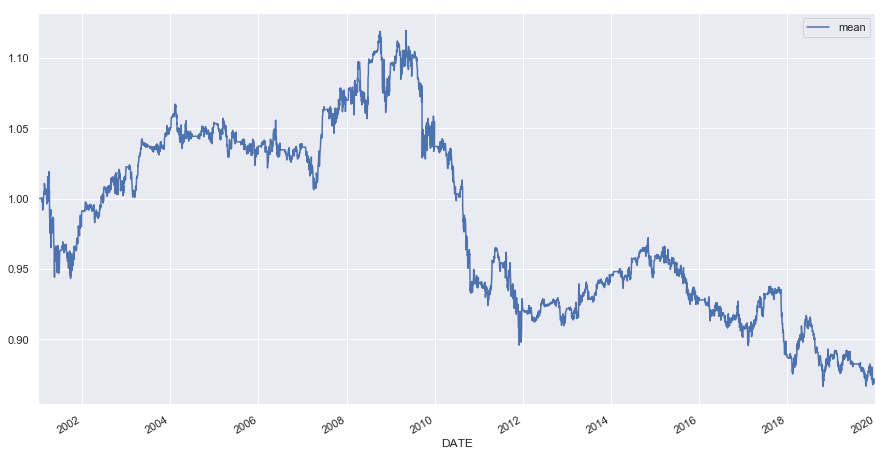

In [49]:
sns.set(rc={'figure.figsize':(15,8)})
backt.plot()

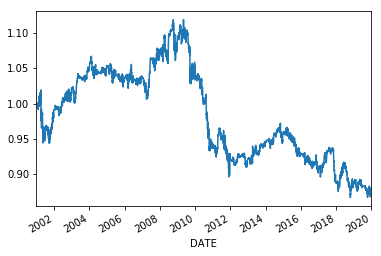

In [25]:
backt['10ssd2.0std'].plot()

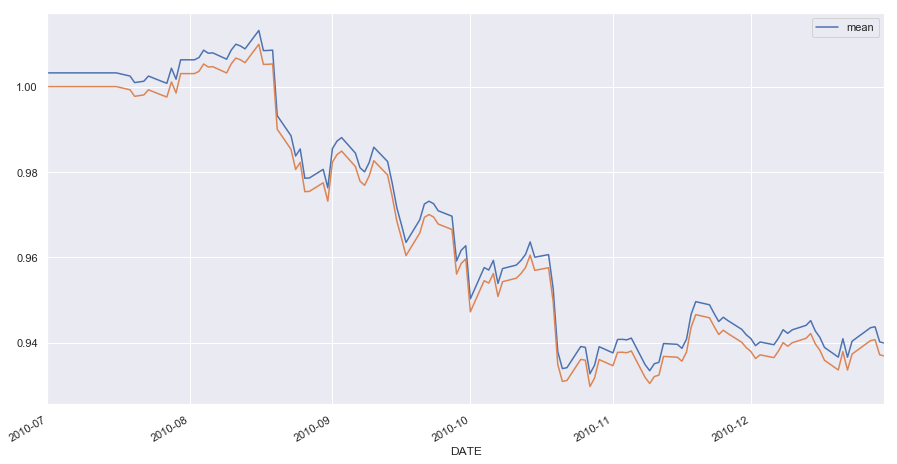

In [55]:
sns.set(rc={'figure.figsize':(15,8)})
backt['2010-07':'2010-12'].plot()
cum_returns.plot()

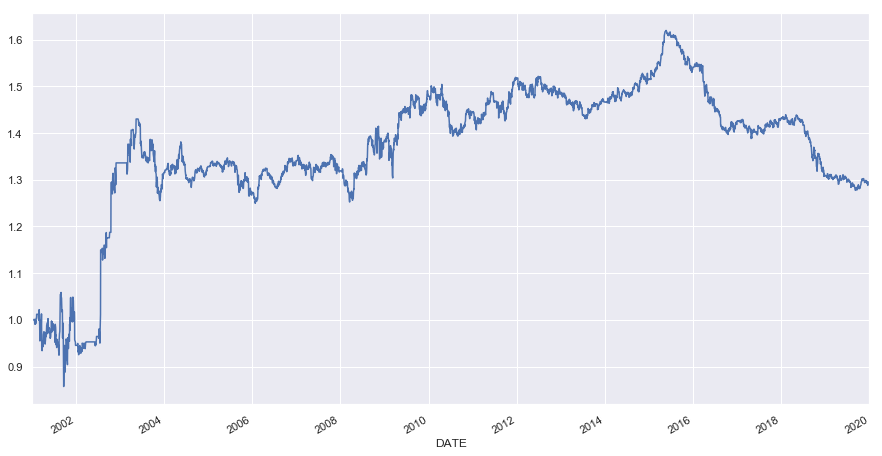

In [171]:
sns.set(rc={'figure.figsize':(15,8)})
cum_returns = (1 + ret).cumprod()
cum_returns.plot()

In [36]:
start = pd.Timestamp('2019-01')
mid = start + relativedelta(months=+12)
end = start + relativedelta(months=+18)

df_formation = (1 + df[start:mid].pct_change()).cumprod()
df_trading = (1 + df[mid:end].pct_change()).cumprod()
vol_df = vol[start:mid]

returns = trading(df_formation, df_trading, vol_df, 10, 0.5)
cum_returns = (1 + returns).cumprod()
print(start, mid, end)

153334.58684738955
BLKBBCGE
SFPNWARN
BSKPSGKN
BLKBBCVN
VAHNWARN
LUKNVATN
SFPNVAHN
BCGETKBP
IRENZUGN
BSKPBCVN
2019-01-01 00:00:00 2020-01-01 00:00:00 2020-07-01 00:00:00


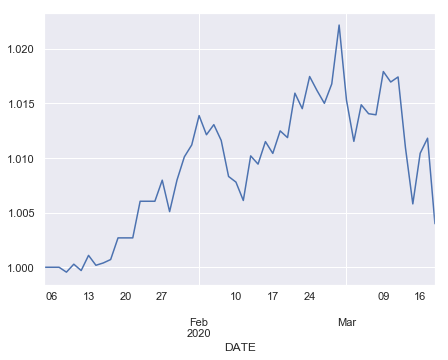

In [37]:
cum_returns.plot()

In [7]:
vol_mean = vol.fillna(0).mean(axis=1)

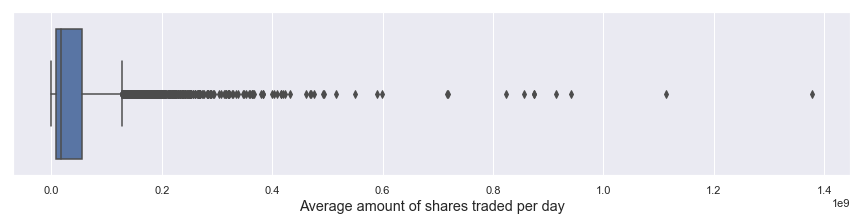

In [14]:
sns.set(rc={'figure.figsize':(15,3)})
c1 = sns.boxplot(vol_mean)
c1 = plt.xlabel("Average amount of shares traded per day", fontsize="large")

##c1 = plt.axvline(stats['25%'], color='g', linestyle='--')

In [15]:
c1.figure.savefig("volume_boxplot.png")

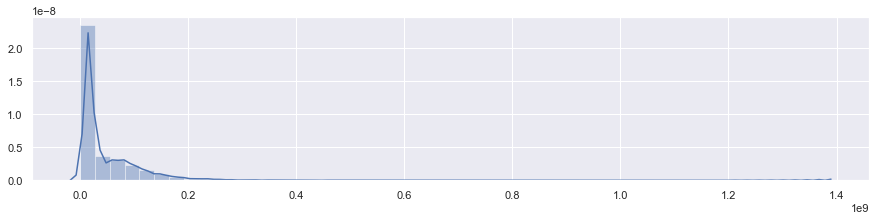

In [76]:
sns.distplot(vol_mean)

In [50]:
start = pd.Timestamp('2004-07')
mid = start + relativedelta(months=+12)
end = start + relativedelta(months=+18)

df_formation = (1 + df[start:mid].pct_change()).cumprod()
df_trading = (1 + df[mid:end].pct_change()).cumprod()

In [51]:
stock1 = 'SLHN'
stock2 = 'VPBN'
stock3 = 'SREN'

st = df_formation[stock1]
nd = df_formation[stock2]
nd = df_formation[stock3]

spread = st - nd
m, u, l = find_entry_exit(spread, 2.0)

signal = create_signal(df_trading, [stock1, stock2], m, u, l)
retet = bt(signal, stock1, stock2)

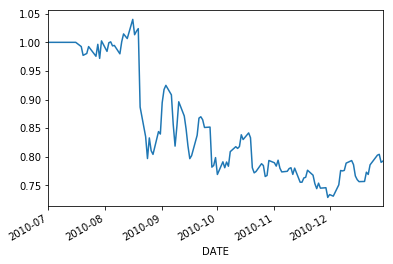

In [21]:
retet.cum_returns.plot()

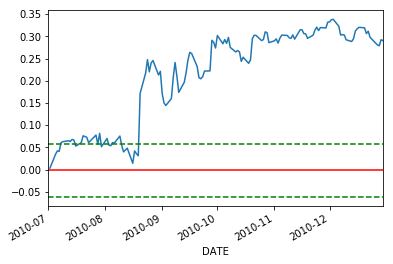

In [22]:
trad_signal = df_trading[stock1] - df_trading[stock2]
trad_signal.plot()
plt.axhline(m, color='r', linestyle='-')
plt.axhline(u, color='g', linestyle='--')
plt.axhline(l, color='g', linestyle='--')

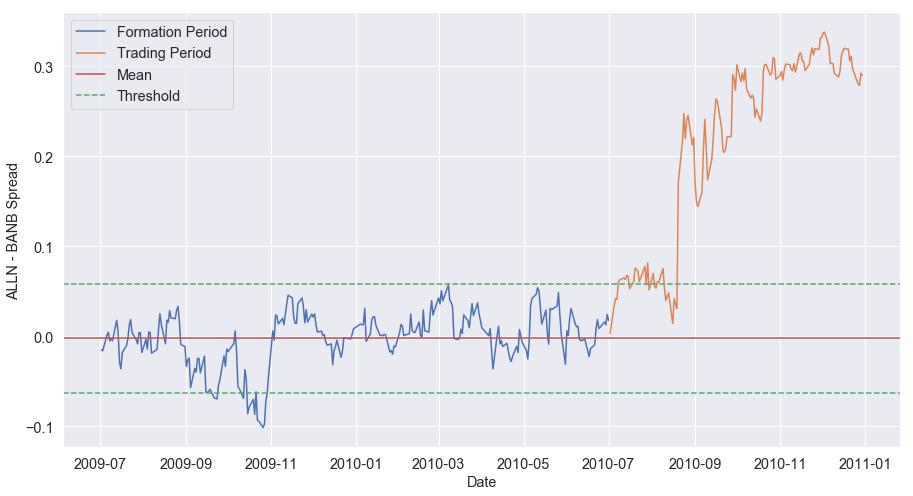

In [25]:
spread = df_trading[stock1] - df_trading[stock2]
for_spread = df_formation[stock1] - df_formation[stock2]

sns.set(rc={'figure.figsize':(15,8)})
fig, ax = plt.subplots()
sprd = plt.plot(for_spread, label='Formation Period')
sprd = plt.plot(spread, label='Trading Period')
sprd = plt.axhline(m, color='r', linestyle='-', label='Mean')
sprd = plt.axhline(u, color='g', linestyle='--', label='Threshold')
sprd = plt.axhline(l, color='g', linestyle='--')
sprd = plt.legend(fontsize="large")
sprd = plt.ylabel("ALLN - BANB Spread", fontsize="large")
sprd = plt.xlabel("Date", fontsize="large")
sprd = ax.tick_params(labelsize='large')

In [26]:
sprd.figure.savefig("ALLNBANB.png")

AttributeError: 'NoneType' object has no attribute 'figure'

In [110]:
#df[stock1]['2009':'2010'].plot()
df[stock2]['2010-08-19':'2010-08-23']

DATE
2010-08-19    65.990629
2010-08-20    56.941914
2010-08-23    53.992333
Name: BANB, dtype: float64

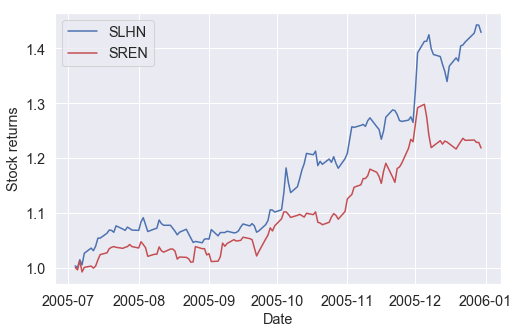

In [67]:
sns.set(rc={'figure.figsize':(8,5)})

fig, ax1 = plt.subplots()
diff = ax1.plot(df_trading[stock1], label='SLHN')
diff = ax1.plot(df_trading[stock3], label='SREN', color='r')
diff = ax1.legend(fontsize="large")
diff = ax1.set_ylabel("Stock returns", fontsize="large")
diff = ax1.set_xlabel("Date", fontsize="large")
diff = ax1.tick_params(labelsize='large')

In [24]:
diff.figure.savefig("SLHNVBPN.png")

In [ ]:
diff = ax2.plot(df_trading[stock1], label='SLHN')
diff = ax2.plot(df_trading[stock3], label='SREN', color='r')
diff = ax2.set_xlabel("Date", fontsize="large")
diff = ax2.legend(fontsize="large")